In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import load, dump
from functools import reduce
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


## If using google colab, run these installations
# !pip install --upgrade eli5
# !pip install --upgrade category_encoders

# reading in data
police1 = pd.read_csv('https://raw.githubusercontent.com/xander-bennett/San-Diego-Police-Data/master/San%20Diego%20Police%20Data/Data/ripa_stops_datasd.csv',sep=',')
police2 = pd.read_csv('https://raw.githubusercontent.com/xander-bennett/San-Diego-Police-Data/master/San%20Diego%20Police%20Data/Data/ripa_stop_reason_datasd.csv',sep=',')
police3 = pd.read_csv('https://raw.githubusercontent.com/xander-bennett/San-Diego-Police-Data/master/San%20Diego%20Police%20Data/Data/ripa_race_datasd.csv',sep=',')
police4 = pd.read_csv('https://raw.githubusercontent.com/xander-bennett/San-Diego-Police-Data/master/San%20Diego%20Police%20Data/Data/ripa_stop_result_datasd.csv',sep=',')
police5 = pd.read_csv('https://raw.githubusercontent.com/xander-bennett/San-Diego-Police-Data/master/San%20Diego%20Police%20Data/Data/ripa_actions_taken_datasd.csv',sep=',')

# Merge dataframes
police_merged_1 = pd.merge(police1, police2, how='inner')
police_merged_2 = pd.merge(police3, police4, how='inner')
police_merged_3= pd.merge(police_merged_1, police_merged_2, how='inner')
police = pd.merge(police_merged_3, police5, how='inner')


print(police.shape)
police.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

(321815, 41)


,stop_id,ori,agency,exp_years,stopdate,stoptime,stopduration,stop_in_response_to_cfs,officer_assignment_key,assignment,intersection,block,land_mark,street,highway_exit,isschool,school_name,cityname,beat,beat_name,pid,isstudent,perceived_limited_english,perceived_age,perceived_gender,gender_nonconforming,gend,gend_nc,perceived_lgbt,reason_for_stop,reason_for_stopcode,reason_for_stop_code_text,reason_for_stop_detail,reason_for_stop_explanation,race,resultkey,result,code,resulttext,action,consented
0,2443,CA0371100,SD,10,2018-07-01,00:01:37,30,0,1,"Patrol, traffic enforcement, field operations",NaN,700.0,NaN,Grand Avenue,NaN,0,NaN,SAN DIEGO,122,Pacific Beach 122,1,0,0,25,Male,0,1,NaN,No,Reasonable Suspicion,64005,647(F) PC - DISORD CONDUCT:ALCOHOL (M) 64005,Officer witnessed commission of a crime,"staggering, unable to safely walk",White,6,Custodial Arrest without warrant,64005.0,647(F) PC - DISORD CONDUCT:ALCOHOL (M) 64005,None,NaN
1,2444,CA0371100,SD,18,2018-07-01,00:03:34,10,0,1,"Patrol, traffic enforcement, field operations",I-5,NaN,NaN,NOBEL DRIVE,NaN,0,NaN,SAN DIEGO,121,Mission Beach 121,1,0,0,25,Male,0,1,NaN,No,Traffic Violation,54106,22350 VC - UNSAFE SPEED:PREVAIL COND (I) 54106,Moving Violation,Speeding,White,2,Warning (verbal or written),54395.0,22349(B) VC - EXC 55MPH SPEED:2 LANE RD (I) 54395,None,NaN
2,2447,CA0371100,SD,1,2018-07-01,00:05:43,15,1,10,Other,NaN,4400.0,NaN,59th Street,NaN,0,NaN,SAN DIEGO,822,El Cerrito 822,1,0,0,30,Male,0,1,NaN,No,Reasonable Suspicion,53072,415(1) PC - FIGHT IN PUBLIC PLACE (M) 53072,Matched suspect description,Both parties involved in argument.,Hispanic/Latino/a,1,No Action,NaN,NaN,Curbside detention,NaN
3,2447,CA0371100,SD,1,2018-07-01,00:05:43,15,1,10,Other,NaN,4400.0,NaN,59th Street,NaN,0,NaN,SAN DIEGO,822,El Cerrito 822,2,0,0,30,Female,0,2,NaN,No,Reasonable Suspicion,53072,415(1) PC - FIGHT IN PUBLIC PLACE (M) 53072,Other Reasonable Suspicion of a crime,Both parties engaged in argument.,Hispanic/Latino/a,1,No Action,NaN,NaN,Curbside detention,NaN
4,2448,CA0371100,SD,3,2018-07-01,00:19:06,5,0,1,"Patrol, traffic enforcement, field operations",NaN,4800.0,NaN,NIAGARA AVE,NaN,0,NaN,SAN DIEGO,614,Ocean Beach 614,1,0,0,23,Male,0,1,NaN,No,Traffic Violation,54106,22350 VC - UNSAFE SPEED:PREVAIL COND (I) 54106,Moving Violation,UNSAFE DRIVING,White,1,No Action,NaN,NaN,None,NaN


## Cleaning Data

In [2]:
police.describe()

,stop_id,exp_years,stopduration,stop_in_response_to_cfs,officer_assignment_key,block,isschool,beat,pid,isstudent,perceived_limited_english,perceived_age,gender_nonconforming,gend,gend_nc,resultkey,code
count,321815.000000,321815.000000,321815.000000,321815.000000,321815.000000,3.008530e+05,321815.000000,321815.000000,321815.000000,321815.000000,321815.000000,321815.000000,321815.000000,321815.000000,206.0,321815.000000,182872.000000
mean,87075.928841,6.330746,47.275497,0.171397,1.592331,5.169807e+03,0.001849,519.708233,1.180128,0.001299,0.028134,36.513267,0.000640,1.249252,5.0,4.816413,48100.769194
std,48303.723628,6.932288,75.959309,0.376856,2.091316,2.099500e+05,0.042959,238.609181,0.796675,0.036017,0.165356,13.030562,0.025293,0.445623,0.0,2.373811,15132.572740
min,2443.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.0,1.000000,3.000000
25%,45366.000000,1.000000,10.000000,0.000000,1.000000,1.200000e+03,0.000000,322.000000,1.000000,0.000000,0.000000,25.000000,0.000000,1.000000,5.0,3.000000,35353.000000
50%,87385.000000,3.000000,20.000000,0.000000,1.000000,3.100000e+03,0.000000,523.000000,1.000000,0.000000,0.000000,35.000000,0.000000,1.000000,5.0,5.000000,54106.000000
75%,129822.000000,9.000000,60.000000,0.000000,1.000000,4.500000e+03,0.000000,712.000000,1.000000,0.000000,0.000000,45.000000,0.000000,1.000000,5.0,7.000000,64005.000000
max,168243.000000,50.000000,1440.000000,1.000000,10.000000,9.999990e+07,1.000000,999.000000,39.000000,1.000000,1.000000,120.000000,1.000000,4.000000,5.0,13.000000,99999.000000


In [26]:
# filtering out extreme age values
df_adv = df_adv[(df_adv['Age'] < 100) & (df_adv['Age'] >= 18)]

TypeError: ignored

In [3]:
police.info()
print()
print(police.isnull().any())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321815 entries, 0 to 321814
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stop_id                      321815 non-null  int64  
 1   ori                          321815 non-null  object 
 2   agency                       321815 non-null  object 
 3   exp_years                    321815 non-null  int64  
 4   stopdate                     321815 non-null  object 
 5   stoptime                     321815 non-null  object 
 6   stopduration                 321815 non-null  int64  
 7   stop_in_response_to_cfs      321815 non-null  int64  
 8   officer_assignment_key       321815 non-null  int64  
 9   assignment                   321815 non-null  object 
 10  intersection                 19370 non-null   object 
 11  block                        300853 non-null  float64
 12  land_mark                    21 non-null      object 
 13 

In [4]:
# checking for duplicates
print('Number of duplicates:', police.duplicated().sum())

Number of duplicates: 454


In [0]:
# removing duplicated observations from data
police = police.drop_duplicates()

In [6]:
cols = police.columns.tolist()
cols

['stop_id',
 'ori',
 'agency',
 'exp_years',
 'stopdate',
 'stoptime',
 'stopduration',
 'stop_in_response_to_cfs',
 'officer_assignment_key',
 'assignment',
 'intersection',
 'block',
 'land_mark',
 'street',
 'highway_exit',
 'isschool',
 'school_name',
 'cityname',
 'beat',
 'beat_name',
 'pid',
 'isstudent',
 'perceived_limited_english',
 'perceived_age',
 'perceived_gender',
 'gender_nonconforming',
 'gend',
 'gend_nc',
 'perceived_lgbt',
 'reason_for_stop',
 'reason_for_stopcode',
 'reason_for_stop_code_text',
 'reason_for_stop_detail',
 'reason_for_stop_explanation',
 'race',
 'resultkey',
 'result',
 'code',
 'resulttext',
 'action',
 'consented']

In [7]:
# dropping columns for missing values, constant values, irrelevant, etc.
police = police.drop(['agency', 'ori', 'block', 'gend_nc', 
         'highway_exit', 'intersection', 'land_mark',
         'school_name', 'street', 'gender_nonconforming', 
              'pid', 'consented', 'resulttext', 'code',
              'beat', 'resultkey','reason_for_stopcode', 
              'isschool', 'stop_id', 'isstudent','reason_for_stop_code_text',
             'reason_for_stop_explanation','cityname',
             'perceived_gender', 'officer_assignment_key', 'stop_in_response_to_cfs',
             'assignment', 'perceived_lgbt'], axis=1)
police.shape

(321361, 13)

## Feature Engineering

In [8]:
# Narrowing result columns to ticket or non-ticket actions
result_list = ['No Action','Warning (verbal or written)', 'Citation for infraction']
police = police[police.result.isin(result_list)]


# looking at target distributions
ticketing_rate = (police['result'].value_counts() / police.shape[0]) * 100

print('Target Distribution:\n',ticketing_rate)

Target Distribution:
 Citation for infraction        40.516520
Warning (verbal or written)    31.391515
No Action                      28.091965
Name: result, dtype: float64


In [0]:
# Converting stopdate to datetime format
# Engineering month, day features
# A year feature isn't necessary because all stops were over a one year period

def convert_to_int(df_column):
    boolean_list = []
    for i in df_column:
        boolean_list.append(int(i))
    df_column = boolean_list
    return df_column


police['stopdate'] = pd.to_datetime(police.stopdate, infer_datetime_format=True)
police['month'] = police['stopdate'].dt.month
police['day'] = police['stopdate'].dt.day


# Only including clean data rows from stoptime. This removes 28 rows
police = police[police['stoptime'].str.len()<=8]

# Now binning stoptimes by hour of the day. 0-24
police['stop_hour'] = pd.to_datetime(police['stoptime']).dt.hour


# Further binning stop_hour into chunks of time. Conventionally, i think more tickets will happen at odd hours
# (Like 2 in the morning or something)
police['morning'] = (police['stop_hour'] < 12) & (police['stop_hour'] >= 6)
police['afternoon'] = (police['stop_hour'] >= 12) & (police['stop_hour'] < 19)
police['night'] = (police['stop_hour'] >= 19) | (police['stop_hour'] < 6) | (police['stop_hour'] == 0)

# creating weekend/weekday timestamp columns
police['weekday'] = police['stopdate'].dt.weekday < 5
police['weekend'] = police['stopdate'].dt.weekday > 5

# converting all booleans to ints

police['afternoon'] = convert_to_int(police['afternoon'])
police['morning'] = convert_to_int(police['morning'])
police['night'] = convert_to_int(police['night'])
police['weekday'] = convert_to_int(police['weekday'])
police['weekend'] = convert_to_int(police['weekend'])

# engineering weekday feature for readability

weekday_names = {0 :'Monday', 1: 'Tuesday', 2:'Wednesday', 3: 'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

weekday_list = []

for i in police['stopdate'].dt.weekday:
    weekday_list.append(weekday_names[i])

police['day_of_week'] = weekday_list


# encode timestamp_month feature
police['month'] = ['January' if x == 1
                        else 'February' if x == 2
                        else 'March' if x == 3
                        else 'April' if x == 4
                        else 'May' if x == 5
                        else 'June' if x == 6
                        else 'July' if x == 7
                        else 'August' if x == 8
                        else 'September' if x == 9
                        else 'October' if x == 10
                        else 'November' if x == 11
                        else 'December' if x == 12
                        else 'NaN'
                        for x in police['month']]


police = police.drop(columns=['stopdate','stoptime'])

In [0]:
# re-encoding some features

police = police.rename(columns={'gend':'gender'})

police['gender'] = ['male' if x == 1
                    else 'female' if x == 2
                    else 'NaN'
                    for x in police['gender']]
                    



In [11]:
police.result.value_counts()

Citation for infraction        46452
Warning (verbal or written)    35991
No Action                      32208
Name: result, dtype: int64

In [12]:
police['citation'] = police['result'] == 'Citation for infraction'

police.drop(columns='result')

target = "citation"

police.head()

,exp_years,stopduration,beat_name,perceived_limited_english,perceived_age,gender,reason_for_stop,reason_for_stop_detail,race,result,action,month,day,stop_hour,morning,afternoon,night,weekday,weekend,day_of_week,citation
1,18,10,Mission Beach 121,0,25,male,Traffic Violation,Moving Violation,White,Warning (verbal or written),None,July,1,0,0,0,1,0,1,Sunday,False
2,1,15,El Cerrito 822,0,30,male,Reasonable Suspicion,Matched suspect description,Hispanic/Latino/a,No Action,Curbside detention,July,1,0,0,0,1,0,1,Sunday,False
3,1,15,El Cerrito 822,0,30,female,Reasonable Suspicion,Other Reasonable Suspicion of a crime,Hispanic/Latino/a,No Action,Curbside detention,July,1,0,0,0,1,0,1,Sunday,False
4,3,5,Ocean Beach 614,0,23,male,Traffic Violation,Moving Violation,White,No Action,None,July,1,0,0,0,1,0,1,Sunday,False
16,4,3,Colina Del Sol 826,0,30,male,Traffic Violation,"Non-moving Violation, including Registration V...",Black/African American,No Action,None,July,1,0,0,0,1,0,1,Sunday,False


## Data Visualization

In [0]:
# functions being used for data visualization

def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data)
        
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])
        
def cross_correlation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
    print(corr)

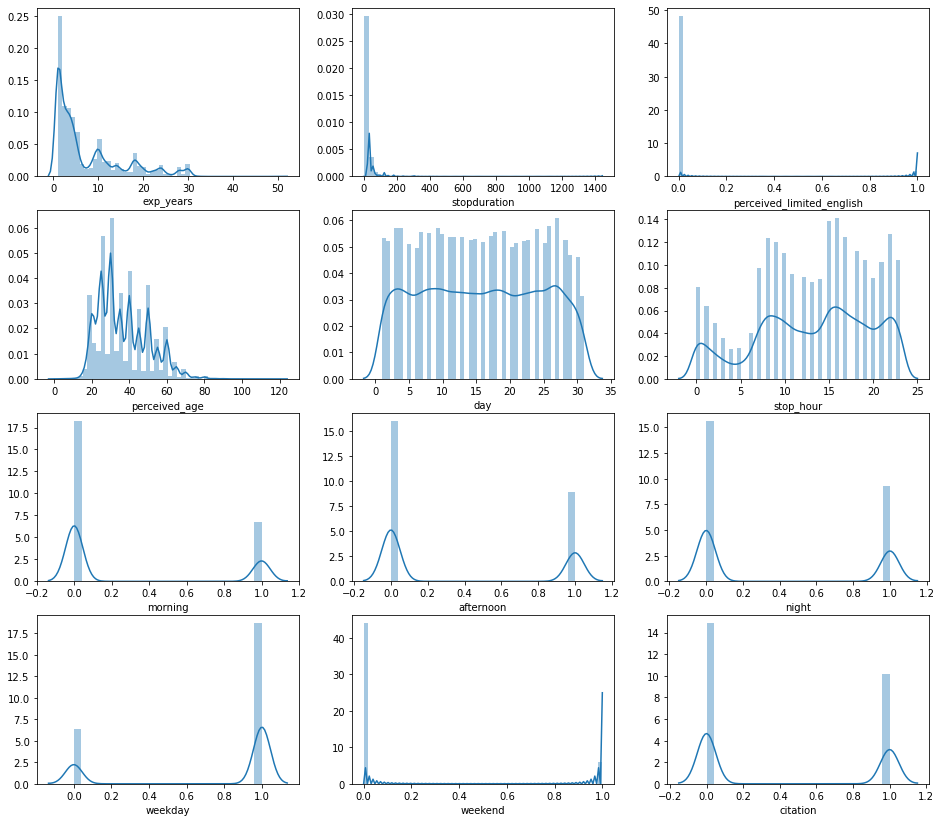

In [14]:
# isolating numerical features
num_vars = police.select_dtypes(exclude=['object', 'datetime64']).columns

# Creating distribution plots
creating_distplot((16,18), police, num_vars);
creating_distplot;

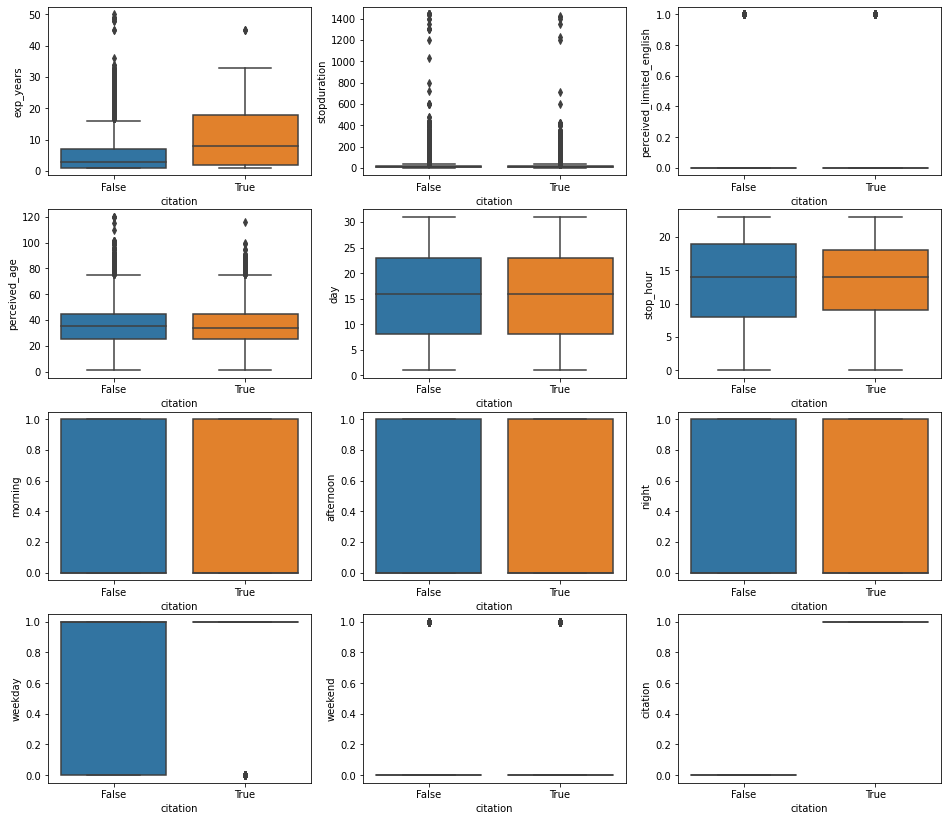

In [20]:
# Generating boxplots with respect to our target feature
target = "citation"
features = ['exp_years', 'stop_hour', ]

creating_boxplots((16,18), target, num_vars, police);

                           exp_years  stopduration  ...   weekend  citation
exp_years                   1.000000     -0.041969  ...  0.009128  0.286218
stopduration               -0.041969      1.000000  ...  0.000633  0.004429
perceived_limited_english   0.007455      0.004863  ... -0.004317  0.006072
perceived_age               0.010607     -0.039547  ... -0.024279 -0.003764
day                        -0.005377      0.008750  ... -0.006865 -0.000490
stop_hour                   0.025208     -0.027509  ...  0.007748  0.025340
morning                     0.055301     -0.015990  ... -0.050378  0.049874
afternoon                   0.058176     -0.035385  ...  0.030821  0.091243
night                      -0.108325      0.049713  ...  0.015642 -0.136111
weekday                     0.000356     -0.008761  ... -0.629069  0.018165
weekend                     0.009128      0.000633  ...  1.000000 -0.011994
citation                    0.286218      0.004429  ... -0.011994  1.000000

[12 rows x 

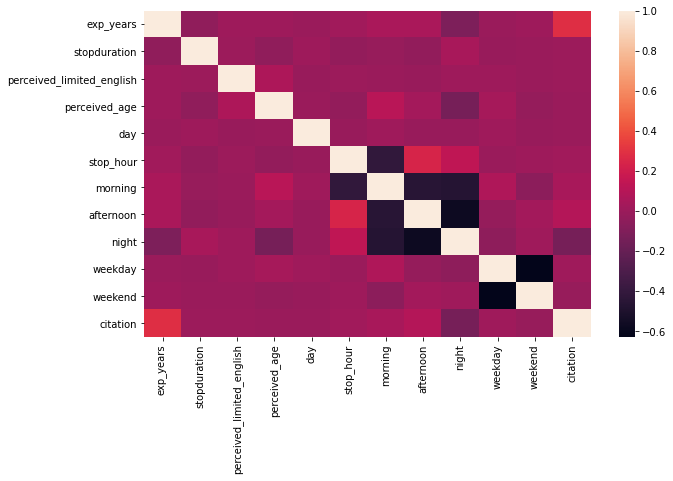

In [16]:
cross_correlation(police)

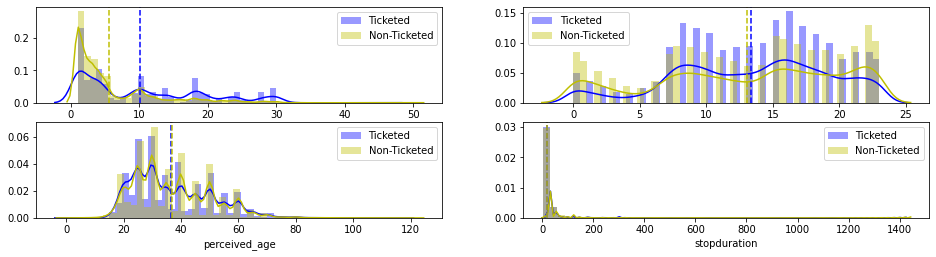

In [18]:
# Subsetting by 'citation received'!
ticketed_df = (police["citation"] == True)
non_ticketed_df = (police["citation"] == False)

# Creating the plots
features = ['exp_years', 'stop_hour', 'perceived_age',  'stopduration']
labels = ['Ticketed', "Non-Ticketed"]

def creating_plots(features, labels):
    plt.figure(figsize=(16,6))
    for feature in features:
        plt.subplot(3, 2, features.index(feature)+1)
        sns.distplot(police[feature][ticketed_df], label=labels[0], color="b")
        sns.distplot(police[feature][non_ticketed_df], label=labels[1], color="y")
        plt.axvline(police[feature][ticketed_df].mean(), linestyle = '--', color="b")
        plt.axvline(police[feature][non_ticketed_df].mean(), linestyle = '--', color="y")
        plt.legend()

creating_plots(features, labels)

## Machine Learning

In [0]:
# get features and target

target = 'citation'

features = police.columns.drop('citation')

In [13]:
features

Index(['exp_years', 'stopduration', 'stop_in_response_to_cfs',
       'officer_assignment_key', 'assignment', 'beat_name',
       'perceived_limited_english', 'perceived_age', 'gend', 'perceived_lgbt',
       'reason_for_stop', 'reason_for_stop_detail', 'race', 'action', 'year',
       'day', 'stop_hour', 'morning', 'afternoon', 'night'],
      dtype='object')

In [14]:
police.shape

(114651, 21)

In [15]:
police.isnull().sum()

exp_years                       0
stopduration                    0
stop_in_response_to_cfs         0
officer_assignment_key          0
assignment                      0
beat_name                       0
perceived_limited_english       0
perceived_age                   0
gend                            0
perceived_lgbt                  0
reason_for_stop                 0
reason_for_stop_detail       5461
race                            0
result                          0
action                          0
year                            0
day                             0
stop_hour                       0
morning                         0
afternoon                       0
night                           0
dtype: int64

In [16]:
police = police.dropna()
police.isnull().sum()

exp_years                    0
stopduration                 0
stop_in_response_to_cfs      0
officer_assignment_key       0
assignment                   0
beat_name                    0
perceived_limited_english    0
perceived_age                0
gend                         0
perceived_lgbt               0
reason_for_stop              0
reason_for_stop_detail       0
race                         0
result                       0
action                       0
year                         0
day                          0
stop_hour                    0
morning                      0
afternoon                    0
night                        0
dtype: int64

In [17]:
train = police
train.shape

(109190, 21)

In [18]:
from sklearn.model_selection import train_test_split

# Split train into train & test, then will split train again into train and val
train, test = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=42)
train.shape, test.shape

((87352, 21), (21838, 21))

In [19]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['result'], random_state=42)
train.shape,val.shape,test.shape

((69881, 21), (17471, 21), (21838, 21))

In [20]:
# The app has a max of 100 MB. so going make a smaller data set for the app to make predictions on.
# The notebook will still make predictions on the full data set, there will just be a separate dataset for the app.
app_train, app_val = train_test_split(train, train_size=50000, test_size=18363, 
                              stratify=train['result'], random_state=42)
train.shape,val.shape,test.shape, app_train.shape, app_val.shape

((69881, 21), (17471, 21), (21838, 21), (50000, 21), (18363, 21))

In [21]:
# Arrange data into X features matrix and y target vector
target = 'result'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

# And for the app data
app_train_X = app_train.drop(columns=target)
app_train_y = app_train[target]
app_val_X = app_val.drop(columns=target)
app_val_y = app_val[target]
# Check shapes
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)
print('app_train_X shape', app_train_X.shape)
print('app_train_y shape', app_train_y.shape)
print('app_val_X shape', app_val_X.shape)
print('app_val_y shape', app_val_y.shape)

X_train shape (69881, 20)
y_train shape (69881,)
X_val shape (17471, 20)
y_val shape (17471,)
X_test shape (21838, 20)
y_test shape (21838,)
app_train_X shape (50000, 20)
app_train_y shape (50000,)
app_val_X shape (18363, 20)
app_val_y shape (18363,)


# Get accuracy score for majority baseline

In [22]:
# Get accuracy score for majority class baseline
y_train.value_counts(normalize=True)

Citation for infraction        0.420000
Warning (verbal or written)    0.324752
No Action                      0.255248
Name: result, dtype: float64

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.42001030278747636

# Create Model - Random Forest

In [24]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Instantiate the class
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42, max_depth=20)
)
# Fit on training set, test on val set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

# Now predicting on test
y_pred = pipeline.predict(X_test)
print('Test Accuracy', accuracy_score(y_test, y_pred))

Validation Accuracy 0.7375078701848778
Test Accuracy 0.739170253686235


In [25]:
y_pred = pipeline.predict(X_test)
print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.739170253686235


In [0]:
# This forest is for the app
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

app_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, max_depth=20)
)

pipeline.fit(app_train_X, app_train_y)
app_y_pred = pipeline.predict(app_val_X)
print('Validation Accuracy', accuracy_score(app_val_y, app_y_pred))

In [0]:
# Pickling pipeline
from joblib import dump
dump(pipeline, 'pipeline.joblib1', compress=True)

In [0]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n=20
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
# Going to get permutation importance


# eli5 doesn't work well with pipelines, so need to decosntruct a little bit for it to work
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# Going to instantiate the permuter class to get the permutation importance
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy', 
    n_iter=2, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

In [0]:
print('Shape before removing features:', X_train.shape)

In [0]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

print('Shape after removing features:', X_train.shape)

In [0]:
X_val = X_val[features]

In [0]:
from sklearn.impute import SimpleImputer
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

# ROC AUC

In [0]:
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train);

In [0]:
#  get accuracy score for model
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

In [0]:
# define confusion matrix function
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

In [0]:
plot_confusion_matrix(y_val, y_pred);

In [0]:
# get precision and recall
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
print(classification_report(y_val, y_pred))

In [0]:
# get ROC AUC score for model

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

In [0]:
# Plot ROC curve

tpr, fpr, thresholds = roc_curve(y_val=='Citation for infraction', y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

# Exploratory Visual analysis

In [0]:
police.exp_years.value_counts(normalize=True)

In [0]:
import seaborn as sns
sns.distplot(police.exp_years);

In [0]:
police.action

In [0]:
police_ticket = police[police['result'] == 'Citation for infraction']

In [0]:
police_no_ticket = police[police['result'] != 'Citation for infraction']

In [0]:
# Looks like three out of the five highest percentage time slots for getting a ticket are during the afternoon commute
# The third highest, though not in the afternoon, is during the morning commute. From 8-9AM
police_ticket['stop_hour'].value_counts(normalize=True).plot(kind='bar');
print(police_ticket['stop_hour'].value_counts(normalize=True))

In [0]:
# it seems like the time of day when you're most likely to get off with just a warning or less would be at 10PM.
# Possible reasons could be that, it's too early for most people to be staggeringly drunk. That likelihood increases the later it gets
print(police_no_ticket['stop_hour'].value_counts(normalize=True))
police_no_ticket['stop_hour'].value_counts().plot(kind='bar');

In [0]:
police_no_ticket['exp_years'].value_counts().plot(kind='bar');
print(police_no_ticket['exp_years'].value_counts(normalize=True))

In [0]:
police_ticket['exp_years'].value_counts().plot(kind='bar');
print(police_ticket['exp_years'].value_counts(normalize=True))

In [0]:
print(police.exp_years.value_counts())
print(police_no_ticket.exp_years.value_counts())
print(police_ticket.exp_years.value_counts())

In [0]:
9289 / (9289 + 17929)

In [0]:
police_ticket['day'].value_counts().plot(kind='bar');

In [0]:
police_ticket['day'].value_counts(normalize=True)

In [0]:
police_no_ticket['day'].value_counts().plot(kind='bar');

In [0]:
police_no_ticket['day'].value_counts()

In [0]:
police_ticket.reason_for_stop_detail.value_counts(normalize=True)

In [0]:
police_no_ticket.reason_for_stop_detail.value_counts(normalize=True)

In [0]:
police_ticket['stopduration'].value_counts(normalize=True)

In [0]:
police_no_ticket['stopduration'].value_counts(normalize=True)